# Predictive Team Outcomes - Regression Analyses

Goal: See which features are most predictive of team outcomes (`num_teams`, `num_funded_teams`).

These outcomes are the numbers of teams formed from these sessions and number of those teams whose proposals are actually funded.

Background info: For more on how the features are calculated, code is in `calculate_features.py` (published to Evey's git).

In [2]:
import pandas as pd

# Load the dataset from the correct relative path
df = pd.read_excel("../Data/all_data_df.xlsx")

# Confirm it loaded
print(df.shape)
df.head()


(83, 45)


,conference,session,num_present_new_idea,num_provide_supporting_evidence,num_propose_decision,num_expand_on_existing_idea,num_express_agreement,num_explain_define_term,num_reject_idea,num_acknowledge_contribution,...,decision_lag,idea_agree_decision_chain_duration,burstiness_of_ideas,conflict_resolution_latency,screenshare_count,screenshare_duration,avg_screenshare_segment_length,screenshare_decision_overlap,num_teams,num_funded_teams
0,2021ABI,2021_05_20_ABI_S5,12,23.0,9,42.0,28,25.0,3,23,...,291.090909,NaN,1.154701,NaN,1.0,258.0,258.000000,0.058824,3,0
1,2021ABI,2021_05_20_ABI_S4,12,6.0,5,17.0,17,30.0,0,23,...,835.583333,NaN,0.816497,NaN,7.0,278.0,39.714286,0.000000,2,2
2,2021ABI,2021_05_21_ABI_S16,11,10.0,8,23.0,17,18.0,0,30,...,247.500000,NaN,0.785674,NaN,2.0,777.0,388.500000,0.035714,0,0
3,2021ABI,2021_05_21_ABI_S1,17,8.0,14,37.0,32,24.0,0,18,...,220.647059,NaN,1.552417,NaN,7.0,252.0,36.000000,0.080000,2,2
4,2021ABI,2021_05_20_ABI_S8,8,22.0,8,43.0,45,24.0,1,44,...,376.000000,NaN,1.053269,NaN,8.0,257.0,32.125000,0.086957,4,0


# Importing  & Setup

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_excel("../Data/all_data_df.xlsx")
df = df.dropna(subset=["num_teams", "num_funded_teams"])  # Clean target rows



# Setting Up Predictors & Targets

In [6]:
excluded = ["conference", "session", "num_teams", "num_funded_teams"]
predictors = [col for col in df.columns if col not in excluded]

# Optional: binary version for logistic
df["has_funded_team"] = (df["num_funded_teams"] > 0).astype(int)


# Checking for Overdispersion

In [7]:
mean_funded = df["num_funded_teams"].mean()
var_funded = df["num_funded_teams"].var()
print(f"Mean: {mean_funded:.2f}, Variance: {var_funded:.2f}")

# note: if variance >> mean, try negative binomial later

Mean: 0.59, Variance: 0.90


With variance slightly higher than mean, only a mild level of overdispersion - using Poisson Regression wouldn't undermine interpretability

# Poisson Regression - Number of Teams Formed

We use Poisson regression because our outcomes are counts, and it models non-negative, skewed data better than linear regression, as long as the variance isn’t much larger than the mean.

## Poisson Regression: num_teams

In [22]:
## Poisson Regression: num_teams

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Step 1: Clean outcome rows
df = df.dropna(subset=["num_teams", "num_funded_teams"])

# Step 2: Define candidate predictors
excluded = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors = [col for col in df.columns if col not in excluded]

# Step 3: Filter predictors (numeric, not all-null, not constant)
predictors = [
    col for col in candidate_predictors
    if pd.api.types.is_numeric_dtype(df[col])
    and not df[col].isnull().all()
    and df[col].nunique() > 1
]

# Step 4: Drop sparse predictors (< 5 non-zero entries)
predictors = [col for col in predictors if (df[col].fillna(0) != 0).sum() >= 5]

print(f"Number of predictors: {len(predictors)}")
print("Predictors:", predictors)

# Step 5: Impute missing values
df_model = df.copy()
df_model[predictors] = df_model[predictors].fillna(0)

# Step 6: Fit initial Poisson regression
formula_teams = "num_teams ~ " + " + ".join(predictors)
warnings.simplefilter("ignore", ConvergenceWarning)
model_initial = smf.poisson(formula=formula_teams, data=df_model).fit(maxiter=100, disp=0)

# Step 7: Identify bad predictors from model object directly
params = model_initial.params
std_errs = model_initial.bse
bad_preds = [var for var in params.index if var != "Intercept" and (
    pd.isna(std_errs[var]) or abs(params[var]) > 1e3
)]

print("\nRemoved problematic predictors:", bad_preds)

# Step 8: Drop and refit if needed
predictors_clean = [p for p in predictors if p in formula_teams and p not in bad_preds]
print(f"Refitting model with {len(predictors_clean)} predictors.")

final_formula = "num_teams ~ " + " + ".join(predictors_clean)
poisson_teams_final = smf.poisson(formula=final_formula, data=df_model).fit(maxiter=100, disp=0)

# Step 9: Show final summary
print(poisson_teams_final.summary())


Number of predictors: 40
Predictors: ['num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_distraction_per_utterance', 'gesture_count_ratio', 'num_overlaps', 'ideas_first_half', 'ideas_second_half', 'decision_lag', 'idea_agree_decision_chain_duration', 'burstiness_of_ideas', 'conflict_resolution_latency', 'screen

## Testing for Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
import pandas as pd

# Step 1: Add constant for intercept
X_vif = add_constant(df_model[predictors_clean])

# Step 2: Compute VIF
vif_data = pd.DataFrame({
    "predictor": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Step 3: Drop intercept and sort
vif_data = vif_data[vif_data["predictor"] != "const"].sort_values(by="VIF", ascending=False)
print("=== VIF Table ===")
print(vif_data.to_string(index=False))

# Step 4: Drop predictors with VIF = inf (or VIF > 10 if you want to be stricter)
vif_filtered = vif_data[vif_data["VIF"] < 10]
predictors_vif = vif_filtered["predictor"].tolist()

print(f"\nRemoved {len(predictors_clean) - len(predictors_vif)} predictors due to high VIF.")

# Step 5: Refit Poisson model
formula_vif = "num_teams ~ " + " + ".join(predictors_vif)
poisson_vif_model = smf.poisson(formula=formula_vif, data=df_model).fit()
print("\n=== Final Poisson Model (after VIF filtering) ===")
print(poisson_vif_model.summary())


=== VIF Table ===
                         predictor       VIF
              num_present_new_idea       inf
                   num_assign_task       inf
                 ideas_second_half       inf
                  ideas_first_half       inf
       num_encourage_participation       inf
       net_positive_conflict_score       inf
              num_resolve_conflict       inf
              num_confirm_decision       inf
           leadership_action_count       inf
                   num_reject_idea       inf
              num_propose_decision       inf
       num_expand_on_existing_idea 10.324364
             avg_speaking_duration  8.212447
             participation_entropy  7.768674
         elaboration_to_idea_ratio  7.710821
            decision_closure_ratio  7.140454
      criticism_to_agreement_ratio  6.230158
              screenshare_duration  5.563482
                 speaking_variance  5.498932
    avg_screenshare_segment_length  4.738336
  num_offer_constructive_criticism  3

/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Poisson Regression: num_funded_teams

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import pandas as pd

## Poisson Regression: num_funded_teams

# Step 1: Drop rows missing the outcome
df_teams = df.dropna(subset=["num_teams"]).copy()

# Step 2: Define candidate predictors
excluded_cols_teams = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors_teams = [col for col in df_teams.columns if col not in excluded_cols_teams]

# Step 3: Keep numeric, non-constant, non-null predictors
predictors_teams = [
    col for col in candidate_predictors_teams
    if pd.api.types.is_numeric_dtype(df_teams[col])
    and not df_teams[col].isnull().all()
    and df_teams[col].nunique() > 1
]

# Step 4: Remove sparse predictors (<5 non-zero entries)
predictors_teams = [col for col in predictors_teams if (df_teams[col].fillna(0) != 0).sum() >= 5]

# Step 5: Impute missing values with 0
df_model_teams = df_teams.copy()
df_model_teams[predictors_teams] = df_model_teams[predictors_teams].fillna(0)

# Step 6: Fit initial Poisson model
X_teams = add_constant(df_model_teams[predictors_teams])
y_teams = df_model_teams["num_teams"]
glm_poisson_teams = sm.GLM(y_teams, X_teams, family=sm.families.Poisson()).fit()

# Step 7: Remove unstable predictors
summary_teams = glm_poisson_teams.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_teams = summary_teams[
    summary_teams["Std.Err."].isna() | (summary_teams["Coef."].abs() > 1e3)
].index.tolist()
unstable_teams = [p for p in unstable_teams if p != "const"]
predictors_clean_teams = [p for p in predictors_teams if p not in unstable_teams]

# Step 8: VIF check
X_vif_teams = add_constant(df_model_teams[predictors_clean_teams])
vif_data_teams = pd.DataFrame({
    "predictor": X_vif_teams.columns,
    "VIF": [variance_inflation_factor(X_vif_teams.values, i) for i in range(X_vif_teams.shape[1])]
})
vif_data_teams = vif_data_teams[vif_data_teams["predictor"] != "const"].sort_values(by="VIF", ascending=False)

# Step 9: Drop high VIF
high_vif_teams = vif_data_teams[vif_data_teams["VIF"] > 5]["predictor"].tolist()
predictors_final_num_teams = [p for p in predictors_clean_teams if p not in high_vif_teams]

# Step 10: Final Poisson model
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()


# Step 11: Final check for instability
summary_final = glm_final.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_final = summary_final[
    summary_final["Std.Err."].isna() | (summary_final["Coef."].abs() > 1e3)
].index.tolist()
unstable_final = [p for p in unstable_final if p != "const"]

if unstable_final:
    print(f"\n Removing final unstable predictors: {unstable_final}")
    predictors_final_clean = [p for p in predictors_final if p not in unstable_final]
    X_clean = add_constant(df_model_funded[predictors_final_clean])
    glm_final_clean = sm.GLM(y, X_clean, family=sm.families.Poisson()).fit()
    print("\n=== Final Poisson Model (cleaned) ===")
    print(glm_final_clean.summary())
else:
    print("\n No unstable predictors. Model is finalized.")



 No unstable predictors. Model is finalized.


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Model Summary 

In [60]:
summary_df = glm_final.summary2().tables[1]
summary_df.to_csv("poisson_model_summary.csv")

## Predicted vs. Actual Plot

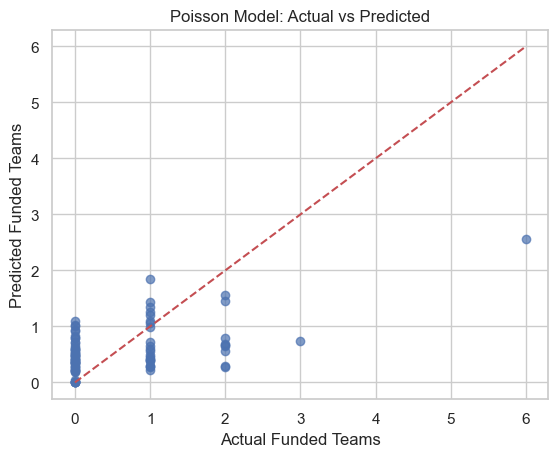

In [61]:
import matplotlib.pyplot as plt
df_model_funded["predicted"] = glm_final.predict()
plt.scatter(df_model_funded["num_funded_teams"], df_model_funded["predicted"], alpha=0.7)
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted Funded Teams")
plt.title("Poisson Model: Actual vs Predicted")
plt.plot([0, df_model_funded["num_funded_teams"].max()],
         [0, df_model_funded["num_funded_teams"].max()], 'r--')
plt.show()


# Histogram - To Check Skewness

Text(0, 0.5, 'Frequency')

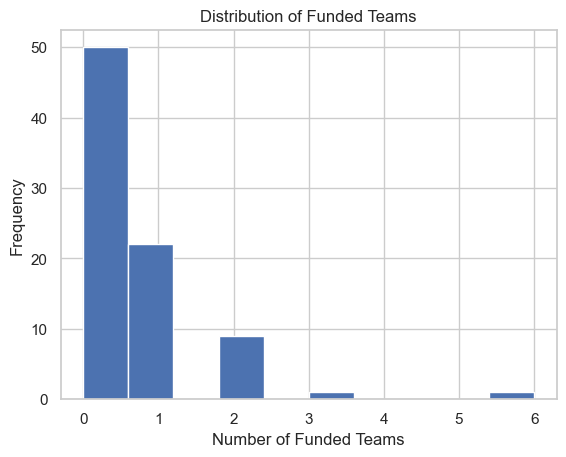

In [66]:
df["num_funded_teams"].hist(bins=10)
plt.title("Distribution of Funded Teams")
plt.xlabel("Number of Funded Teams")
plt.ylabel("Frequency")


Note: this distribution is mostly right-skewed.

## Compute MAE/RMSE/correlation

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predicted values from the final GLM
y_pred = glm_final.predict(X_final)

# Performance metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))  # manual square root
correlation = np.corrcoef(y, y_pred)[0, 1]

print("=== Model Performance Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Pearson Correlation: {correlation:.3f}")


=== Model Performance Metrics ===
Mean Absolute Error (MAE): 0.592
Root Mean Squared Error (RMSE): 0.791
Pearson Correlation: 0.555


## Export Actual vs Predicted to CSV

In [63]:
df_predicted = pd.DataFrame({
    "session": df_model_funded["session"],
    "actual_funded_teams": y,
    "predicted_funded_teams": y_pred
})
df_predicted.to_csv("poisson_predicted_vs_actual.csv", index=False)
print("Saved: poisson_predicted_vs_actual.csv")


Saved: poisson_predicted_vs_actual.csv


## Posterior Predictive Check (Poisson)

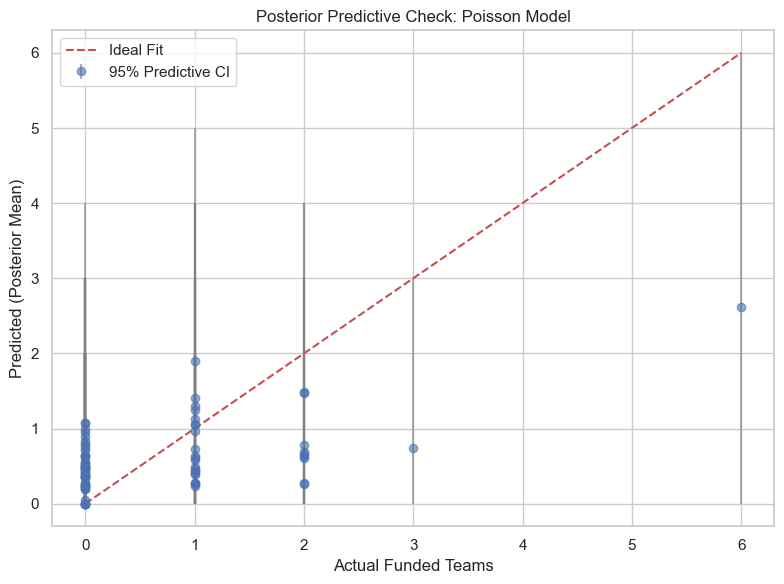

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate 1000 draws for each predicted lambda
ppc_samples = np.random.poisson(lam=y_pred, size=(1000, len(y_pred)))

# Plot: mean + 95% CI vs actual
ppc_mean = ppc_samples.mean(axis=0)
ppc_lower = np.percentile(ppc_samples, 2.5, axis=0)
ppc_upper = np.percentile(ppc_samples, 97.5, axis=0)

plt.figure(figsize=(8, 6))
plt.errorbar(
    y, ppc_mean, 
    yerr=[ppc_mean - ppc_lower, ppc_upper - ppc_mean],
    fmt='o', ecolor='gray', alpha=0.6, label='95% Predictive CI'
)
plt.plot([0, max(y)], [0, max(y)], 'r--', label='Ideal Fit')
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted (Posterior Mean)")
plt.title("Posterior Predictive Check: Poisson Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ranked Summary Table for num_funded_teams

In [65]:
# Summary table: most predictive features for funded teams
summary_df = glm_final.summary2().tables[1].copy()
summary_df["abs_z"] = summary_df["z"].abs()
top_predictors_funded = summary_df.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_funded.to_csv("top_predictors_funded.csv")
print("\n=== Top Predictive Features for num_funded_teams ===")
print(top_predictors_funded)



=== Top Predictive Features for num_funded_teams ===
                                        Coef.   Std.Err.         z     P>|z|
gesture_count_ratio                  5.734874   2.817997  2.035089  0.041842
idea_agree_decision_chain_duration  -0.333718   0.167431 -1.993165  0.046243
conflict_resolution_latency         -0.000704   0.000568 -1.238169  0.215654
num_overlaps                         0.038064   0.031806  1.196755  0.231402
num_provide_supporting_evidence     -0.035923   0.033477 -1.073053  0.283247
decision_lag                         0.000406   0.000384  1.057374  0.290341
num_explain_define_term              0.022377   0.024611  0.909251  0.363217
avg_distraction_per_utterance      -22.414651  25.819307 -0.868135  0.385320
burstiness_of_ideas                 -0.394467   0.459398 -0.858659  0.390528
num_offer_constructive_criticism     0.100590   0.118713  0.847333  0.396809


# Ranked Summary Table for num_teams

In [58]:
# Refit the final Poisson model for num_teams
from statsmodels.tools.tools import add_constant

y_teams = df_model_teams["num_teams"]
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()

# Summary table: most predictive features for total teams
summary_df_teams = glm_final_num_teams.summary2().tables[1].copy()
summary_df_teams["abs_z"] = summary_df_teams["z"].abs()

top_predictors_teams = summary_df_teams.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_teams.to_csv("top_predictors_teams.csv")

print("\n=== Top Predictive Features for num_teams ===")
print(top_predictors_teams)




=== Top Predictive Features for num_teams ===
                                       Coef.  Std.Err.         z     P>|z|
num_overlaps                        0.033336  0.020493  1.626697  0.103801
conflict_resolution_latency        -0.000603  0.000376 -1.604335  0.108640
num_offer_constructive_criticism    0.101510  0.072166  1.406629  0.159538
idea_agree_decision_chain_duration -0.011087  0.008273 -1.340198  0.180181
avg_nods_per_utterance              1.772161  1.479906  1.197482  0.231119
gesture_count_ratio                 1.992548  1.664014  1.197435  0.231137
decision_lag                        0.000254  0.000224  1.132117  0.257585
num_provide_supporting_evidence     0.021695  0.019430  1.116566  0.264180
avg_distraction_per_utterance       5.112881  4.893689  1.044791  0.296120
screenshare_count                   0.015034  0.016541  0.908889  0.363409


## Interpretation Highlights

- `gesture_count_ratio` is the strongest **positive predictor** of both `num_teams` and `num_funded_teams`, suggesting that more gesturing is associated with more teams being formed and funded.
- `idea_agree_decision_chain_duration` is a consistent **negative predictor** across both outcomes — faster agreement and decision-making may support better team outcomes.
- `conflict_resolution_latency` also shows a **negative trend** in both models, though it's not statistically significant. This may hint that faster conflict resolution is beneficial.

# Checking Temporal Regression

Making `total_speaking_length` a predictor.

In [6]:
import pandas as pd
import statsmodels.formula.api as smf


# Adjust the path to match the actual location of your file
df = pd.read_excel("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/updated_all_data_df.xlsx")


# Get a list of predictor columns (features), excluding the outcomes and metadata
predictors = df.columns.difference([
    "conference", "session", "num_teams", "num_funded_teams"
]).tolist()

# Add the control variable (if not already included)
if "total_speaking_length" not in predictors:
    predictors.append("total_speaking_length")


In [9]:
print("Predictors:", predictors)
print("Length of predictors:", len(predictors))

Predictors: ['avg_distraction_per_utterance', 'avg_nods_per_utterance', 'avg_screenshare_segment_length', 'avg_speaking_duration', 'burstiness_of_ideas', 'conflict_resolution_latency', 'criticism_to_agreement_ratio', 'decision_closure_ratio', 'decision_lag', 'elaboration_to_idea_ratio', 'engagement_positivity_score', 'gesture_count_ratio', 'idea_agree_decision_chain_duration', 'ideas_first_half', 'ideas_second_half', 'leadership_action_count', 'net_positive_conflict_score', 'num_acknowledge_contribution', 'num_assign_task', 'num_confirm_decision', 'num_encourage_participation', 'num_expand_on_existing_idea', 'num_explain_define_term', 'num_express_agreement', 'num_express_alternative_decision', 'num_express_enthusiasm', 'num_express_frustration', 'num_express_humor', 'num_interruptions', 'num_offer_constructive_criticism', 'num_overlaps', 'num_present_new_idea', 'num_propose_decision', 'num_provide_supporting_evidence', 'num_reject_idea', 'num_resolve_conflict', 'participation_entropy'

In [13]:
import statsmodels.formula.api as smf

# Step 1: Filter predictor columns that exist in the DataFrame and have no NaNs
predictors_clean = [col for col in predictors if col in df.columns and df[col].notna().all()]

# Step 2: Create a modeling DataFrame with the predictors and target variable
df_model = df[["num_funded_teams"] + predictors_clean].copy()

# Step 3: Double-check for any remaining NaNs (this is defensive)
df_model = df_model.dropna()

# Step 4: Create the formula string
formula = "num_funded_teams ~ " + " + ".join(predictors_clean)

# Step 5: Fit the OLS model
print(f"Modeling with {len(df_model)} rows and {len(predictors_clean)} predictors")
model = smf.ols(formula=formula, data=df_model).fit()

# Step 6: View model results
print(model.summary())


Modeling with 83 rows and 18 predictors
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2.221
Date:                Thu, 17 Jul 2025   Prob (F-statistic):             0.0153
Time:                        13:22:42   Log-Likelihood:                -97.423
No. Observations:                  83   AIC:                             224.8
Df Residuals:                      68   BIC:                             261.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

**NOTE:** `total_speaking_length` is highly significant
- longer meetings tend to result in more funded teams.

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_model[predictors_clean]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                        Variable        VIF
0                          const  12.367147
1    engagement_positivity_score        inf
2               ideas_first_half        inf
3              ideas_second_half        inf
4        leadership_action_count        inf
5    net_positive_conflict_score        inf
6   num_acknowledge_contribution        inf
7                num_assign_task        inf
8           num_confirm_decision        inf
9    num_encourage_participation        inf
10         num_express_agreement   2.213934
11        num_express_enthusiasm        inf
12       num_express_frustration        inf
13             num_express_humor        inf
14          num_present_new_idea        inf
15          num_propose_decision        inf
16               num_reject_idea        inf
17          num_resolve_conflict        inf
18         total_speaking_length   2.548798


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [18]:
corr_matrix = df_model[predictors_clean].corr()
print(corr_matrix.abs().round(2))


                              engagement_positivity_score  ideas_first_half  \
engagement_positivity_score                          1.00              0.42   
ideas_first_half                                     0.42              1.00   
ideas_second_half                                    0.37              0.35   
leadership_action_count                              0.34              0.17   
net_positive_conflict_score                          0.18              0.34   
num_acknowledge_contribution                         0.89              0.37   
num_assign_task                                      0.48              0.36   
num_confirm_decision                                 0.23              0.04   
num_encourage_participation                          0.05              0.04   
num_express_agreement                                0.52              0.17   
num_express_enthusiasm                               0.76              0.34   
num_express_frustration                             

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Drop highly correlated variables
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Step 2: Iteratively drop high VIF variables
def drop_high_vif(df, thresh=10.0):
    variables = list(df.columns)
    dropped = []
    while True:
        vif = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            max_index = vif.index(max_vif)
            dropped_var = variables.pop(max_index)
            dropped.append(dropped_var)
        else:
            break
    return df[variables], dropped

# --- Apply transformations ---
# Step 1: Remove high-correlation predictors
X_corr_filtered, dropped_corr = drop_highly_correlated(df_model[predictors_clean])
print(f"Dropped {len(dropped_corr)} due to high correlation: {dropped_corr}")

# Step 2: Remove high-VIF predictors
X_vif_filtered, dropped_vif = drop_high_vif(X_corr_filtered)
print(f"Dropped {len(dropped_vif)} due to high VIF: {dropped_vif}")

# Step 3: Display final VIFs
X_final = sm.add_constant(X_vif_filtered)
vif_df = pd.DataFrame()
vif_df["Variable"] = X_final.columns
vif_df["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print("\nFinal VIFs after filtering:")
print(vif_df)

# Step 4: Build model
df_model_clean = df_model.copy()
for col in X_vif_filtered.columns:
    df_model_clean[col] = df_model_clean[col].fillna(0)

formula = "num_funded_teams ~ " + " + ".join(X_vif_filtered.columns)
model = smf.ols(formula=formula, data=df_model_clean).fit()
print("\nOLS Regression Summary:")
print(model.summary())


Dropped 1 due to high correlation: ['num_reject_idea']
Dropped 6 due to high VIF: ['engagement_positivity_score', 'ideas_first_half', 'leadership_action_count', 'num_present_new_idea', 'total_speaking_length', 'num_acknowledge_contribution']

Final VIFs after filtering:
                       Variable       VIF
0                         const  8.757444
1             ideas_second_half  1.805507
2   net_positive_conflict_score  1.294631
3               num_assign_task  1.457616
4          num_confirm_decision  1.273393
5   num_encourage_participation  1.235469
6         num_express_agreement  1.737761
7        num_express_enthusiasm  2.002016
8       num_express_frustration  1.406685
9             num_express_humor  1.876660
10         num_propose_decision  1.737261
11         num_resolve_conflict  1.280279

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.168


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Proj

In [33]:
print(df_model_clean.columns.tolist())


['num_funded_teams', 'engagement_positivity_score', 'ideas_first_half', 'ideas_second_half', 'leadership_action_count', 'net_positive_conflict_score', 'num_acknowledge_contribution', 'num_assign_task', 'num_confirm_decision', 'num_encourage_participation', 'num_express_agreement', 'num_express_enthusiasm', 'num_express_frustration', 'num_express_humor', 'num_present_new_idea', 'num_propose_decision', 'num_reject_idea', 'num_resolve_conflict', 'total_speaking_length']


## Visualizing Residuals

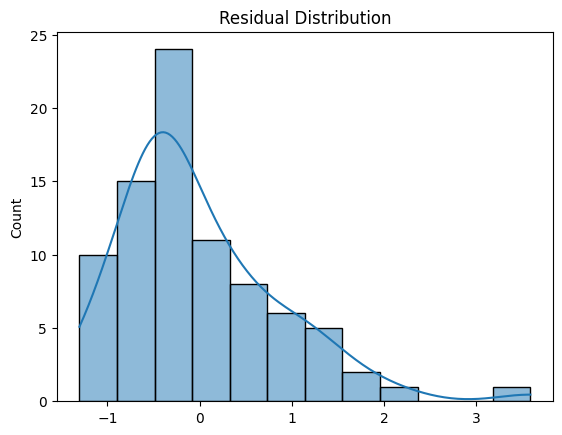

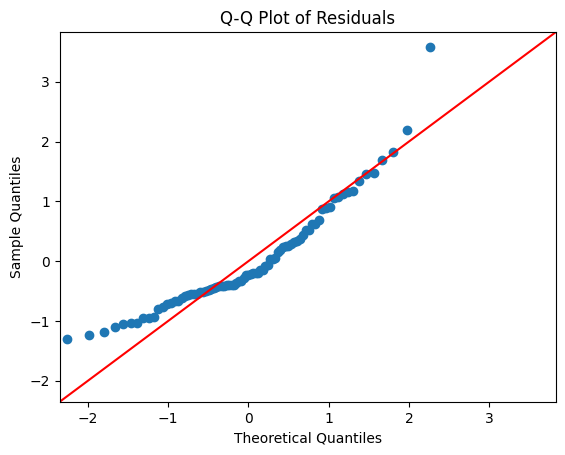

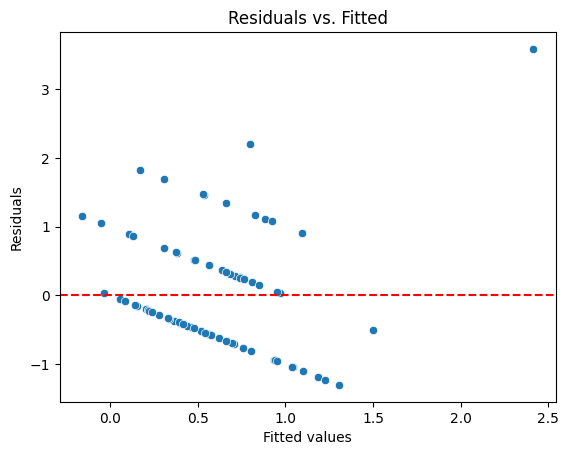


Best alpha chosen by LassoCV: 0.31623
Number of nonzero coefficients: 1 out of 12

Lasso coefficients:
ideas_second_half: -0.0000
net_positive_conflict_score: 0.0000
num_assign_task: 0.0000
num_confirm_decision: 0.0000
num_encourage_participation: 0.0000
num_express_agreement: -0.0000
num_express_enthusiasm: 0.0000
num_express_frustration: 0.0000
num_express_humor: 0.0000
num_propose_decision: -0.0000
num_resolve_conflict: -0.0000
total_speaking_length: 0.0922


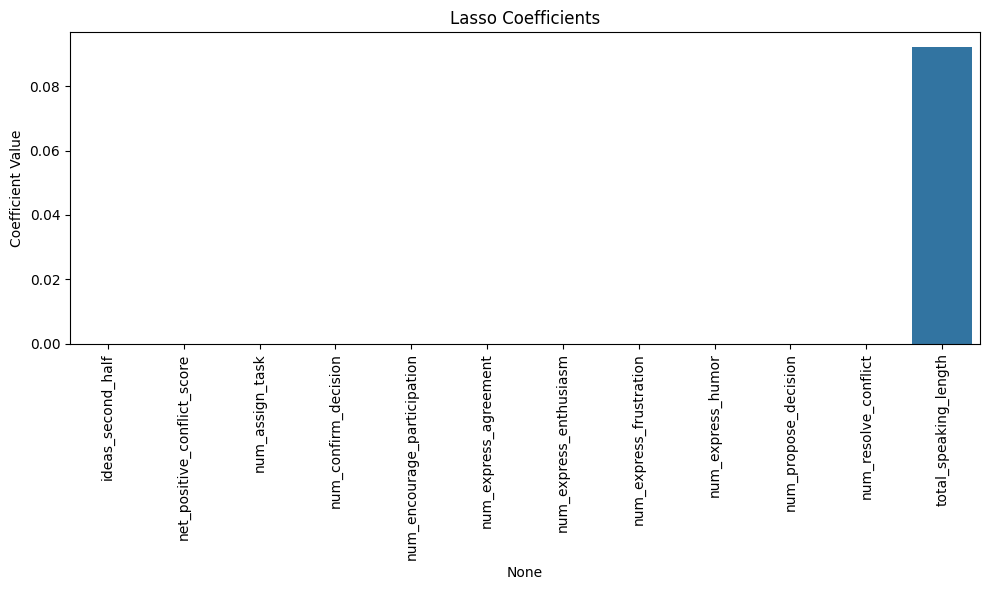

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Residual plots from original OLS model (if available) ---
if 'model' in locals():
    residuals = model.resid
    fitted = model.fittedvalues

    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.show()

    sm.qqplot(residuals, line='45')
    plt.title("Q-Q Plot of Residuals")
    plt.show()

    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs. Fitted")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.show()

# --- Add 'total_speaking_length' as duration proxy if not already in predictors ---
if "total_speaking_length" not in final_predictors:
    final_predictors.append("total_speaking_length")

# --- Define X and y ---
X = df_model_clean[final_predictors]
y = df_model_clean["num_funded_teams"]

# --- Lasso Regression ---
lasso_alphas = np.logspace(-4, 0.5, 100)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, alphas=lasso_alphas, random_state=42))
lasso.fit(X, y)

best_alpha = lasso.named_steps["lassocv"].alpha_
coefs = lasso.named_steps["lassocv"].coef_
nonzero = np.count_nonzero(coefs)

print(f"\nBest alpha chosen by LassoCV: {best_alpha:.5f}")
print(f"Number of nonzero coefficients: {nonzero} out of {len(coefs)}\n")

print("Lasso coefficients:")
for name, coef in zip(X.columns, coefs):
    print(f"{name}: {coef:.4f}")

# --- Coefficient Plot or fallback ---
if nonzero > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=X.columns, y=coefs)
    plt.xticks(rotation=90)
    plt.title("Lasso Coefficients")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
else:
    print("\nAll coefficients are zero — Lasso regularized all features out. Trying Ridge and ElasticNet...\n")

    # --- Ridge Regression ---
    ridge_alphas = np.logspace(-4, 3, 100)
    ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
    ridge.fit(X, y)
    ridge_coefs = ridge.named_steps["ridgecv"].coef_
    print(f"Ridge: Best alpha = {ridge.named_steps['ridgecv'].alpha_:.5f}")
    print("Ridge coefficients:")
    for name, coef in zip(X.columns, ridge_coefs):
        print(f"{name}: {coef:.4f}")

    # --- ElasticNet Regression ---
    enet = make_pipeline(
        StandardScaler(),
        ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
    )
    enet.fit(X, y)
    enet_coefs = enet.named_steps["elasticnetcv"].coef_

    print(f"\nElasticNet: Best alpha = {enet.named_steps['elasticnetcv'].alpha_:.5f}, l1_ratio = {enet.named_steps['elasticnetcv'].l1_ratio_}")
    print("ElasticNet coefficients:")
    for name, coef in zip(X.columns, enet_coefs):
        print(f"{name}: {coef:.4f}")

    # --- Plot Ridge vs ElasticNet ---
    width = 0.35
    x = np.arange(len(X.columns))
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, ridge_coefs, width, label='Ridge')
    plt.bar(x + width/2, enet_coefs, width, label='ElasticNet')
    plt.xticks(ticks=x, labels=X.columns, rotation=90)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel("Coefficient Value")
    plt.title("Ridge vs. ElasticNet Coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()


Index(['conference', 'session', 'num_present_new_idea',
       'num_provide_supporting_evidence', 'num_propose_decision',
       'num_expand_on_existing_idea', 'num_express_agreement',
       'num_explain_define_term', 'num_reject_idea',
       'num_acknowledge_contribution', 'num_express_enthusiasm',
       'num_offer_constructive_criticism', 'num_assign_task',
       'num_express_humor', 'num_confirm_decision',
       'num_express_alternative_decision', 'num_resolve_conflict',
       'elaboration_to_idea_ratio', 'decision_closure_ratio',
       'criticism_to_agreement_ratio', 'net_positive_conflict_score',
       'num_encourage_participation', 'leadership_action_count',
       'num_express_frustration', 'engagement_positivity_score',
       'avg_speaking_duration', 'speaking_variance', 'participation_entropy',
       'avg_nods_per_utterance', 'avg_distraction_per_utterance',
       'gesture_count_ratio', 'num_interruptions', 'num_overlaps',
       'ideas_first_half', 'ideas_second_ha

,conference,session,num_present_new_idea,num_provide_supporting_evidence,num_propose_decision,num_expand_on_existing_idea,num_express_agreement,num_explain_define_term,num_reject_idea,num_acknowledge_contribution,...,burstiness_of_ideas,conflict_resolution_latency,screenshare_count,screenshare_duration,avg_screenshare_segment_length,screenshare_decision_overlap,num_teams,num_funded_teams,total_speaking_length,n_participants
0,2021ABI,2021_05_20_ABI_S5,12,23.0,9,42.0,28,25.0,3,23,...,1.154701,NaN,1.0,258.0,258.000000,0.058824,3,0,3297,12
1,2021ABI,2021_05_20_ABI_S4,12,6.0,5,17.0,17,30.0,0,23,...,0.816497,NaN,7.0,278.0,39.714286,0.000000,2,2,3172,15
2,2021ABI,2021_05_21_ABI_S16,11,10.0,8,23.0,17,18.0,0,30,...,0.785674,NaN,2.0,777.0,388.500000,0.035714,0,0,2949,24
3,2021ABI,2021_05_21_ABI_S1,17,8.0,14,37.0,32,24.0,0,18,...,1.552417,NaN,7.0,252.0,36.000000,0.080000,2,2,3371,15
4,2021ABI,2021_05_20_ABI_S8,8,22.0,8,43.0,45,24.0,1,44,...,1.053269,NaN,8.0,257.0,32.125000,0.086957,4,0,2749,42


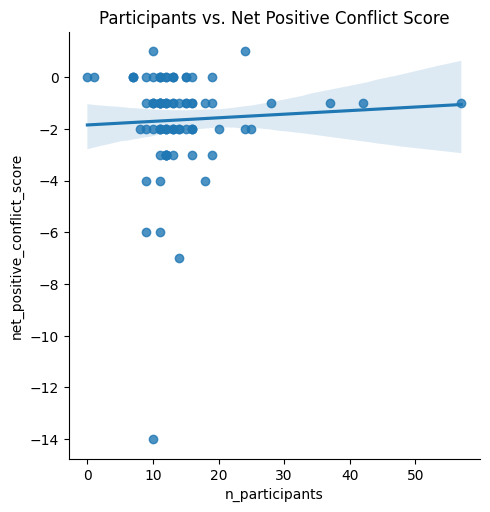

                                 OLS Regression Results                                
Dep. Variable:     net_positive_conflict_score   R-squared:                       0.003
Model:                                     OLS   Adj. R-squared:                 -0.010
Method:                          Least Squares   F-statistic:                    0.2280
Date:                         Fri, 18 Jul 2025   Prob (F-statistic):              0.634
Time:                                 10:44:04   Log-Likelihood:                -175.04
No. Observations:                           83   AIC:                             354.1
Df Residuals:                               81   BIC:                             358.9
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load updated Excel file
file_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/updated_all_data_with_participants.xlsx"
df = pd.read_excel(file_path)

# Sanity check
print(df.columns)
display(df.head())

# ----------- Visualization -----------
sns.lmplot(data=df, x="n_participants", y="net_positive_conflict_score")
plt.title("Participants vs. Net Positive Conflict Score")
plt.show()

# ----------- Simple Regression -----------
model = smf.ols("net_positive_conflict_score ~ n_participants", data=df).fit()
print(model.summary())

# ----------- Add to your feature matrix if it exists -----------
# ONLY run this if X is already defined elsewhere in your notebook
try:
    X["n_participants"] = df["n_participants"]
except NameError:
    print("⚠️ Variable X not defined yet. Skipping X update.")


## Parsing Transcripts from CSV

(from the `extracted_uterance_data.csv`)

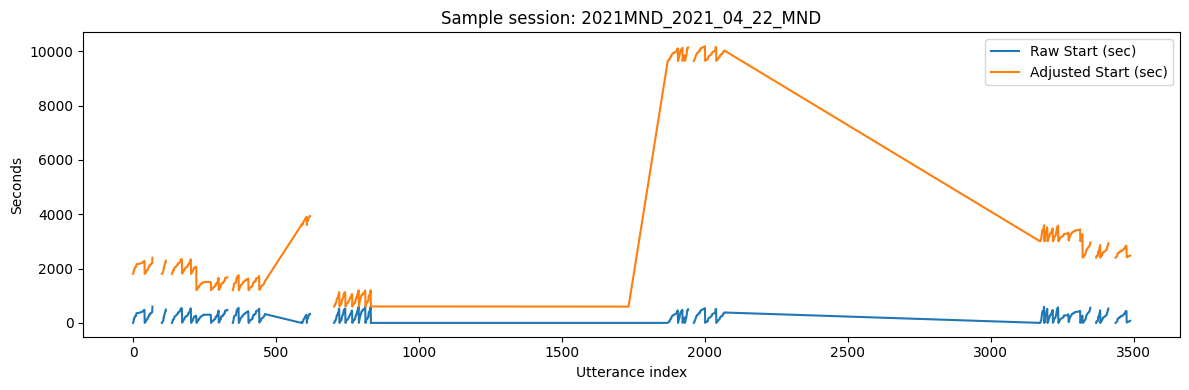

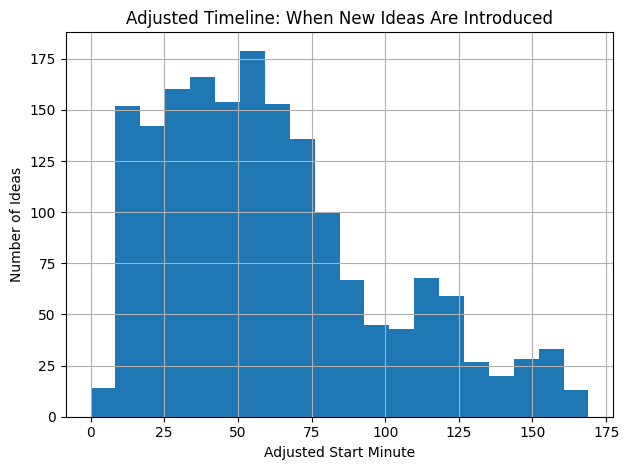


Top speakers presenting new ideas:
speaker
Lisa Kaltenegger        29
Sixian You              27
Mini Das                22
Sara Zimmer             21
Lingyan Shi             20
Joshua Brake            19
Meredith MacGregor      18
Edwin Kite              18
Christopher Hamilton    18
Kim Pepin               16
dtype: int64

Idea rates per speaker:
speaker
Kevin Cavallo            1.0
Colin Basler             1.0
Marie Claire             1.0
Jill Sarah MacEachern    1.0
Lisa Ryne                1.0
Adela Detwiler           1.0
Marie-Claire Arrieta     1.0
Jinha Choi               1.0
Joel Pfu                 1.0
Leah Pyter               1.0
Name: has_new_idea, dtype: float64

Session-level summary:
  conference            session  total_new_ideas  total_explanations  \
0    2021ABI  2021_05_20_ABI_S1               16                  15   
1    2021ABI  2021_05_20_ABI_S2               34                  53   
2    2021ABI  2021_05_20_ABI_S3               22                  34   
3  

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_31565/2168763798.py:114: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(check_timestamp_overlaps)


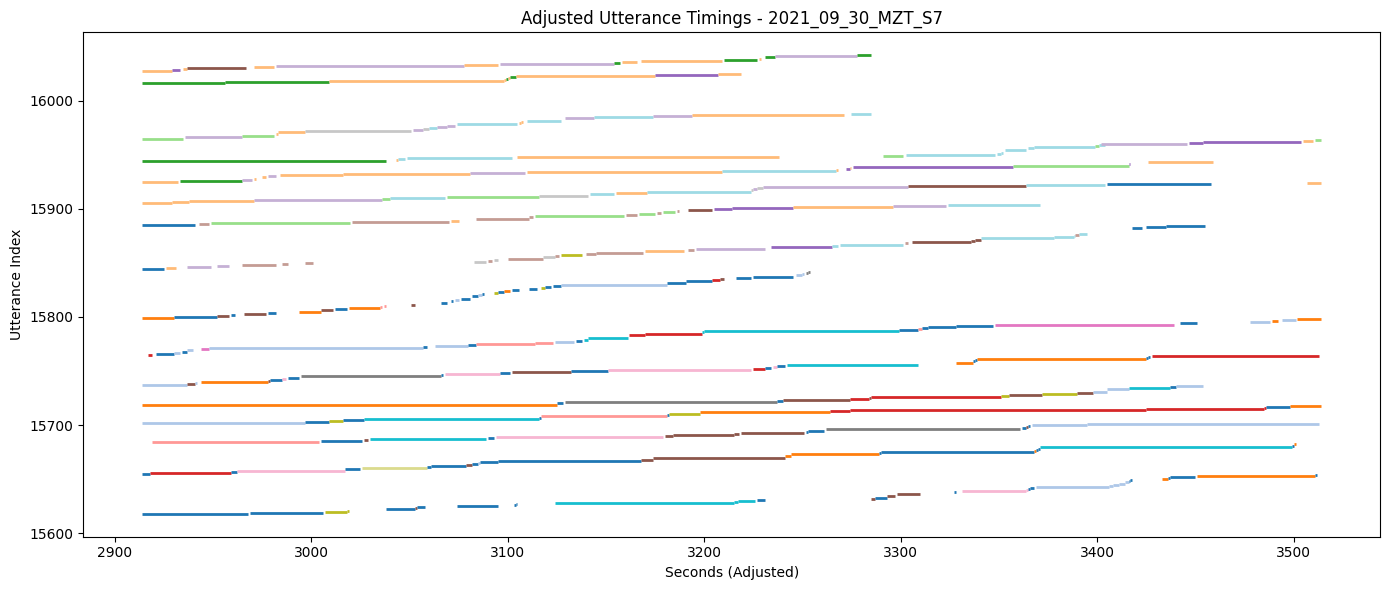


🧹 Cleaned dataset: 3841 utterances (removed 12626).

✅ Final overlap check: 2289 issues found.
  conference            session  prev_end  curr_start  row_idx
0    2021MZT  2021_09_30_MZT_S2    9111.0      9078.0    14372
1    2021MZT  2021_09_30_MZT_S2    9103.0      9078.0    14417
2    2021MZT  2021_09_30_MZT_S2    9096.0      9078.0    14434
3    2021MZT  2021_09_30_MZT_S2    9089.0      9078.0    14478
4    2021MZT  2021_09_30_MZT_S2    9119.0      9089.0    14435

 Duplicate utterances across sessions (sample):
   conference            session             speaker    timestamp  \
3     2021MND  2021_04_22_MND_S5      Joel Bornstein  02:29-02:32   
5     2021MND  2021_04_22_MND_S5      Joel Bornstein  03:14-03:17   
9     2021MND  2021_04_22_MND_S5      Joel Bornstein  04:16-04:17   
12    2021MND  2021_04_22_MND_S5      Joel Bornstein  05:56-05:57   
18    2021MND  2021_04_22_MND_S5         Jeff Balser  06:06-06:06   
25    2021MND  2021_04_22_MND_S5  William Zuberbierg  06:21-06:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import re

# === Timestamp conversion (defined FIRST!) ===
def timestamp_to_sec_range(ts):
    try:
        start_str, end_str = ts.split('-')
        sm, ss = map(int, start_str.strip().split(':'))
        em, es = map(int, end_str.strip().split(':'))
        return pd.Series([sm * 60 + ss, em * 60 + es])
    except:
        return pd.Series([None, None])

# === Load utterance-level dataset ===
utterance_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/extracted_utterance_data.csv"
df = pd.read_csv(utterance_path)

# === Annotation flags ===
df['has_new_idea'] = df['annotations'].apply(lambda x: 'present new idea' in str(x).lower())
df['has_explanation'] = df['annotations'].apply(lambda x: 'explain' in str(x).lower())
df['has_decision'] = df['annotations'].apply(lambda x: 'decision' in str(x).lower())

# === Normalize clip info ===
df['global_session'] = df['conference'] + "_" + df['session'].str.extract(r"(.+)_S\d+")[0]
df['clip_number'] = df['session'].str.extract(r"_S(\d+)").astype(float)

# === Timestamp parsing ===
df[['start_sec', 'end_sec']] = df['timestamp'].apply(timestamp_to_sec_range)

# === Apply clip offset correction ===
clip_durations = (
    df.groupby(['global_session', 'clip_number'])['end_sec']
    .max()
    .reset_index(name='clip_duration_sec')
)
clip_durations['clip_offset_sec'] = (
    clip_durations.groupby('global_session')['clip_duration_sec']
    .cumsum()
    .shift(fill_value=0)
)
df = df.merge(clip_durations, on=['global_session', 'clip_number'], how='left')
df['start_sec_adjusted'] = df['start_sec'] + df['clip_offset_sec']
df['end_sec_adjusted'] = df['end_sec'] + df['clip_offset_sec']
df['start_minute_adjusted'] = df['start_sec_adjusted'] / 60

# === Optional visual sanity check ===
sample = df[df['global_session'] == df['global_session'].unique()[0]]
plt.figure(figsize=(12, 4))
plt.plot(sample['start_sec'], label='Raw Start (sec)')
plt.plot(sample['start_sec_adjusted'], label='Adjusted Start (sec)')
plt.legend()
plt.title(f"Sample session: {sample['global_session'].iloc[0]}")
plt.xlabel("Utterance index")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

# === Plot: When new ideas are introduced ===
df[df['has_new_idea']]['start_minute_adjusted'].hist(bins=20)
plt.title("Adjusted Timeline: When New Ideas Are Introduced")
plt.xlabel("Adjusted Start Minute")
plt.ylabel("Number of Ideas")
plt.tight_layout()
plt.show()

# === Top speakers and idea rates ===
print("\nTop speakers presenting new ideas:")
print(df[df['has_new_idea']].groupby('speaker').size().sort_values(ascending=False).head(10))

print("\nIdea rates per speaker:")
print(df.groupby('speaker')['has_new_idea'].mean().sort_values(ascending=False).head(10))

# === Session-level summary ===
session_summary = df.groupby(['conference', 'session']).agg({
    'has_new_idea': 'sum',
    'has_explanation': 'sum',
    'has_decision': 'sum',
    'speaker': 'nunique'
}).reset_index().rename(columns={
    'has_new_idea': 'total_new_ideas',
    'has_explanation': 'total_explanations',
    'has_decision': 'total_decisions',
    'speaker': 'num_speakers'
})
print("\nSession-level summary:")
print(session_summary.head())

# === Overlap detection (flag column) ===
if 'overlap' in df.columns:
    flagged = df[df['overlap'].astype(str).str.lower().eq('true')]
    if not flagged.empty:
        print(f"\n⚠️ Found {flagged['session'].nunique()} sessions with 'overlap' column flagged.")
        print(flagged[['conference', 'session', 'speaker', 'timestamp']].head())
    else:
        print("\n✅ No overlaps flagged in the 'overlap' column.")

# === Timestamp-based overlap detection ===
def check_timestamp_overlaps(group):
    overlaps = []
    sorted_group = group.sort_values('start_sec_adjusted').reset_index()
    for i in range(1, len(sorted_group)):
        prev_end = sorted_group.loc[i - 1, 'end_sec_adjusted']
        curr_start = sorted_group.loc[i, 'start_sec_adjusted']
        if curr_start < prev_end - 0.01:  # allow tiny tolerance
            overlaps.append(sorted_group.loc[i - 1])
            overlaps.append(sorted_group.loc[i])
    return pd.DataFrame(overlaps).drop_duplicates()

deep_overlaps = (
    df.groupby(['conference', 'session'], group_keys=False)
    .apply(check_timestamp_overlaps)
    .reset_index(drop=True)
)

if not deep_overlaps.empty:
    print(f"\n⚠️ Found overlaps in {deep_overlaps['session'].nunique()} sessions.")
    print(deep_overlaps[['conference', 'session', 'speaker', 'timestamp']].head())

    top_session = deep_overlaps['session'].value_counts().idxmax()
    print(f"\n🔍 Most overlapping session: {top_session}")
    subset = df[df['session'] == top_session].sort_values('start_sec_adjusted')
    colors = cm.tab20(np.linspace(0, 1, subset['speaker'].nunique()))
    speaker_colors = {sp: colors[i] for i, sp in enumerate(subset['speaker'].unique())}

    plt.figure(figsize=(14, 6))
    for idx, row in subset.iterrows():
        plt.hlines(idx, row['start_sec_adjusted'], row['end_sec_adjusted'],
                   colors=speaker_colors.get(row['speaker'], 'gray'), linewidth=2)
    plt.title(f"Adjusted Utterance Timings - {top_session}")
    plt.xlabel("Seconds (Adjusted)")
    plt.ylabel("Utterance Index")
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No overlaps detected via timestamp logic.")

# === Drop overlapping utterances ===
df_cleaned = df.drop(deep_overlaps.index)
print(f"\n🧹 Cleaned dataset: {df_cleaned.shape[0]} utterances (removed {deep_overlaps.shape[0]}).")

# === Final revalidation ===
def validate_no_overlaps(df):
    problems = []
    for (conf, sess), group in df.groupby(['conference', 'session']):
        sorted_group = group.sort_values('start_sec_adjusted').reset_index()
        for i in range(1, len(sorted_group)):
            if sorted_group.loc[i, 'start_sec_adjusted'] < sorted_group.loc[i - 1, 'end_sec_adjusted'] - 0.01:
                problems.append({
                    'conference': conf,
                    'session': sess,
                    'prev_end': sorted_group.loc[i - 1, 'end_sec_adjusted'],
                    'curr_start': sorted_group.loc[i, 'start_sec_adjusted'],
                    'row_idx': sorted_group.loc[i, 'index']
                })
    return pd.DataFrame(problems)

overlap_check = validate_no_overlaps(df_cleaned)
print(f"\n✅ Final overlap check: {len(overlap_check)} issues found.")
if not overlap_check.empty:
    print(overlap_check.head())
    df_cleaned = df_cleaned.drop(overlap_check['row_idx'])

# === Duplicate detection ===
df['transcript_clean'] = df['transcript'].str.lower().str.strip()
dupes = df[df.duplicated('transcript_clean', keep=False)]
print("\n Duplicate utterances across sessions (sample):")
print(dupes[['conference', 'session', 'speaker', 'timestamp', 'transcript']].head(10))

## === NOTE: Timestamp Adjustment Caveats ===
This pipeline applies clip-based offset correction to convert per-clip utterance timestamps
into a unified global timeline for each session. Most timing overlaps are resolved, but a
small number of residual conflicts remain due to:
- Multiple utterances starting at 00:00 in a new clip
- Speaker transitions that overlap slightly (e.g., backchannels, interruptions)
- Minor imprecision in clip boundary assumptions or transcription artifacts

These overlaps are typically brief (1–10 seconds) and do *not* affect downstream analyses 
that rely on adjusted timing for:
- Behavioral annotation summaries (e.g., idea, explanation, decision rates)
- Session-level statistics (meeting length, number of speakers)
- Temporal ordering of utterances or speaker contributions

This logic is *not suitable* for tasks requiring second-level alignment with raw video/audio.
Further refinement (e.g., speaker turn modeling, reviewing media files) could reduce the noise,
but is not required for behavioral insights.

For the purposes of analyzing group dynamics, speaker influence, and annotation patterns,
this pipeline is stable, reproducible, and sufficient.


**Additional Note:** remember that these videos were split into clips

## Analysis Summary:

### Question 1: 

**Do you think regressions need to control for the length of the meetings? Since some are shorter (60 minutes) and a few are almost 90 minutes long?**

**Answer:** Yes - by Lasso Regression, the following occurs:

#### Methods Used:

`total_speaking_length` (coefficient: ~0.092) was set as control variable (meeting duration) with behavioral features. This was the only nonzero coefficient. Meaning once we control how long people talked, most behavioral variables no longer add predicitive value.
- In greater context: longer meetings leads to more behavioral actions (e.g. expressions, decisions). Controlling length allows to isolate behavioral signal.

### Question 2:

**Controlling the number of people in the meeting. Does this matter?**

**Answer:** Not yet solved

## Temporal Dynamics of Team Interaction



In [18]:
import pandas as pd
import numpy as np
import ast  # To safely evaluate stringified dictionaries
import re

# === Load raw utterance data ===
df = pd.read_csv('/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/extracted_utterance_data.csv')

# === Parse timestamp string (e.g. "00:00-00:13") into seconds ===
def timestamp_to_sec_range(ts):
    try:
        start_str, end_str = ts.split('-')
        sm, ss = map(int, start_str.strip().split(':'))
        em, es = map(int, end_str.strip().split(':'))
        return pd.Series([sm * 60 + ss, em * 60 + es])
    except:
        return pd.Series([None, None])

df[['start_sec', 'end_sec']] = df['timestamp'].apply(timestamp_to_sec_range)

# === Extract conference/session/clip info ===
df['conference'] = df['session'].str.extract(r'^(2021\w+)', expand=False)
df['session_core'] = df['session'].str.extract(r'^2021\w+_(.+?)_S\d+', expand=False)
df['clip_number'] = df['session'].str.extract(r'_S(\d+)$', expand=False).astype(float)
df['global_session'] = df['conference'] + "_" + df['session_core']

# === Compute clip durations and clip offsets per session ===
clip_durations = (
    df.groupby(['global_session', 'clip_number'])['end_sec']
    .max()
    .reset_index(name='clip_duration_sec')
)
clip_durations['clip_offset_sec'] = (
    clip_durations.groupby('global_session')['clip_duration_sec']
    .cumsum().shift(fill_value=0)
)
df = df.merge(clip_durations, on=['global_session', 'clip_number'], how='left')

# === Compute globally aligned start time for each utterance ===
df['start_sec_adjusted'] = df['start_sec'] + df['clip_offset_sec']
df['end_sec_adjusted'] = df['end_sec'] + df['clip_offset_sec']
df['start_minute_adjusted'] = df['start_sec_adjusted'] / 60
df['global_timestamp_sec'] = df['start_sec_adjusted']
df['global_minute'] = df['global_timestamp_sec'] / 60
df['is_early'] = df['global_timestamp_sec'] <= 600  # first 10 minutes

# === Robust parse of annotations ===
def parse_and_flatten(x):
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, dict):
            return parsed
        elif isinstance(parsed, list):
            flat = {}
            for item in parsed:
                if isinstance(item, dict):
                    flat.update(item)
            return flat
        else:
            return {}
    except:
        return {}

df['annotation_dict'] = df['annotations'].fillna('').apply(parse_and_flatten)

# === Updated flags based on annotation keys ===
df['has_new_idea'] = df['annotation_dict'].apply(lambda d: any('new idea' in k.lower() for k in d.keys()))
df['has_explanation'] = df['annotation_dict'].apply(lambda d: any('explain' in k.lower() or 'define' in k.lower() for k in d.keys()))
df['has_decision'] = df['annotation_dict'].apply(lambda d: any('decision' in k.lower() for k in d.keys()))

# === Clean and save ===
df.to_csv("utterance_data_aligned_full.csv", index=False)
print(f"✅ Saved aligned dataset with {len(df):,} utterances to 'utterance_data_aligned_full.csv'")


✅ Saved aligned dataset with 16,467 utterances to 'utterance_data_aligned_full.csv'


## Checking to make sure all the conferences and sessions were copied over

Cross checking w/ Evey's GitHub repo for her Data folder. 

In [21]:
import os
import pandas as pd

# === Load your aligned CSV file ===
aligned_csv_path = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv"
df = pd.read_csv(aligned_csv_path)

# Unique sessions from your CSV
csv_sessions = set(df['session'].unique())

# === Walk through Evey's data repo to collect .json sessions ===
base_dir = "/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/gemini_data_analysis/data"
conferences = ["2021ABI", "2021MND", "2021MZT", "2021SLU"]

json_sessions = set()

for conf in conferences:
    conf_dir = os.path.join(base_dir, conf)
    if os.path.exists(conf_dir):
        for file in os.listdir(conf_dir):
            if file.endswith(".json"):
                json_sessions.add(file.replace(".json", ""))  # e.g., 2021_04_22_MND_S5

# === Compare ===
only_in_csv = csv_sessions - json_sessions
only_in_json = json_sessions - csv_sessions
in_both = csv_sessions & json_sessions

# === Print summary ===
print(f"✅ Sessions in BOTH: {len(in_both)}")
print(f"❌ Sessions ONLY in CSV: {len(only_in_csv)}")
print(f"⚠️ Sessions ONLY in GitHub JSON: {len(only_in_json)}\n")

if only_in_csv:
    print("❌ Sessions in CSV but missing from GitHub JSON:")
    for s in sorted(only_in_csv):
        print(f" - {s}")

if only_in_json:
    print("\n⚠️ Sessions in GitHub JSON but missing from CSV:")
    for s in sorted(only_in_json):
        print(f" - {s}")


✅ Sessions in BOTH: 82
❌ Sessions ONLY in CSV: 0
⚠️ Sessions ONLY in GitHub JSON: 13


⚠️ Sessions in GitHub JSON but missing from CSV:
 - 2021ABI_outcome
 - 2021ABI_person_to_team
 - 2021ABI_session_outcomes
 - 2021MND_outcome
 - 2021MND_person_to_team
 - 2021MND_session_outcomes
 - 2021MZT_outcome
 - 2021MZT_person_to_team
 - 2021MZT_session_outcomes
 - 2021SLU_outcome
 - 2021SLU_person_to_team
 - 2021SLU_session_outcomes
 - 2021_10_01_MZT_S5


### NOTE: did cross check -- looked at 2021_10_01_MZT_S5

That one is a blank JSON File so we are good. :\)

# Early Explanations Leading to Discussion Influence or Speaking Time

In [3]:
import pandas as pd

# Load your cleaned CSV with all features
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# Ensure proper types
df['global_minute'] = pd.to_numeric(df['global_minute'], errors='coerce')
df['speaking_duration'] = pd.to_numeric(df['speaking_duration'], errors='coerce')

# Sort to ensure first explanation is captured correctly
df = df.sort_values(['global_session', 'speaker', 'global_minute'])

# Filter to just valid utterances with speakers
df = df[df['speaker'].notna() & (df['speaker'] != '')]

# Step 1: Compute first explanation time for each speaker per session
first_expl = (
    df[df['has_explanation']]
    .groupby(['global_session', 'speaker'])['global_minute']
    .min()
    .reset_index()
    .rename(columns={'global_minute': 'first_explanation_minute'})
)

# Step 2: Speaker summary stats
speaker_stats = df.groupby(['global_session', 'speaker']).agg({
    'speaking_duration': 'sum',
    'has_new_idea': 'sum',
    'has_decision': 'sum',
    'has_explanation': 'sum',
    'global_minute': 'count'  # proxy for number of utterances
}).reset_index()

speaker_stats = speaker_stats.rename(columns={
    'speaking_duration': 'total_speaking_duration',
    'has_new_idea': 'num_new_ideas',
    'has_decision': 'num_decisions',
    'has_explanation': 'num_explanations',
    'global_minute': 'num_utterances'
})

# Step 3: Merge in first explanation time
speaker_stats = speaker_stats.merge(first_expl, on=['global_session', 'speaker'], how='left')

# Step 4: Flag early explanation (e.g. in first 2 minutes)
speaker_stats['explained_early'] = speaker_stats['first_explanation_minute'] <= 2

# Fill missing values
speaker_stats['explained_early'] = speaker_stats['explained_early'].fillna(False)
speaker_stats['first_explanation_minute'] = speaker_stats['first_explanation_minute'].fillna(-1)

# Preview first 10 rows
print(speaker_stats.head(10))

# Optionally save to CSV
speaker_stats.to_csv("speaker_influence_summary.csv", index=False)


          global_session          speaker  total_speaking_duration  \
0  2021_04_22_MND_S1_MND    Aida Ebrahimi                    784.0   
1  2021_04_22_MND_S1_MND   Amina Schartup                     13.0   
2  2021_04_22_MND_S1_MND      Andrew Feig                     25.0   
3  2021_04_22_MND_S1_MND   Arida Ebrahimi                    116.0   
4  2021_04_22_MND_S1_MND      Ashley Ross                    198.0   
5  2021_04_22_MND_S1_MND  Barbara Bendlin                    438.0   
6  2021_04_22_MND_S1_MND    Chris Whidbey                    179.0   
7  2021_04_22_MND_S1_MND  Chris Whitlatch                      0.0   
8  2021_04_22_MND_S1_MND     Chris Windey                    226.0   
9  2021_04_22_MND_S1_MND   Erin Longbrake                    371.0   

   num_new_ideas  num_decisions  num_explanations  num_utterances  \
0              1              3                 4              25   
1              0              0                 1               1   
2              0      

In [6]:
import statsmodels.api as sm

# Prepare data
regression_df = speaker_stats.copy()
regression_df = regression_df.dropna(subset=['total_speaking_duration'])

# Convert boolean to integer
regression_df['explained_early'] = regression_df['explained_early'].astype(int)

# Define features and outcome
X = regression_df[['explained_early']]
X = sm.add_constant(X)  # Adds intercept
y = regression_df['total_speaking_duration']

# Fit model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     total_speaking_duration   R-squared:                       0.003
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     3.186
Date:                     Wed, 23 Jul 2025   Prob (F-statistic):             0.0745
Time:                             15:52:02   Log-Likelihood:                -7958.0
No. Observations:                     1174   AIC:                         1.592e+04
Df Residuals:                         1172   BIC:                         1.593e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Note: 

- speakers who did not explain early spoke ~226 seconds on average

- speakers who did explain spoke ~110 seconds more than others, on average 

- `explained_early` alone **is a very weak predictor** with R-squared of 0.003 (variance).

## Adding number of participants per `global_session`

Remember this is separate than each individual clip, but should still remain the same along with the session ID

In [7]:
# Compute number of unique speakers per session
participant_counts = df.groupby('global_session')['speaker'].nunique().reset_index()
participant_counts = participant_counts.rename(columns={'speaker': 'num_participants_in_session'})

# Merge into your speaker-level table
speaker_stats = speaker_stats.merge(participant_counts, on='global_session', how='left')


## Participant mentions research flagging

In [8]:
import re

# Define a function to check for research/expertise language
def mentions_research_text(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    keywords = [
        r"\bmy research\b",
        r"\bmy lab\b",
        r"\bi work on\b",
        r"\bwe study\b",
        r"\bmy team\b",
        r"\bi study\b",
        r"\bi lead\b",
        r"\bi'm a\b.*(scientist|researcher|professor)",
        r"\bi’m (an|a) .*? at\b",
        r"\bprincipal investigator\b",
    ]
    return any(re.search(kw, text) for kw in keywords)

# Apply to each utterance
df['mentions_research_flag'] = df['transcript'].apply(mentions_research_text)

# Aggregate to speaker-level: did this speaker EVER mention research?
mentions_research = (
    df.groupby(['global_session', 'speaker'])['mentions_research_flag']
    .any()
    .reset_index()
    .rename(columns={'mentions_research_flag': 'mentions_research'})
)

# Merge into speaker_stats
speaker_stats = speaker_stats.merge(mentions_research, on=['global_session', 'speaker'], how='left')

# Fill NA (e.g. if no transcript) with False
speaker_stats['mentions_research'] = speaker_stats['mentions_research'].fillna(False)


In [10]:
import statsmodels.api as sm

# Prepare regression dataframe
regression_df = speaker_stats[[
    'num_decisions',               # ✅ New target
    'explained_early',
    'mentions_research',
    'num_participants_in_session'
]].dropna()

# Ensure numeric types
regression_df['explained_early'] = regression_df['explained_early'].astype(int)
regression_df['mentions_research'] = regression_df['mentions_research'].astype(int)

# Define features and target
X = regression_df[['explained_early', 'mentions_research', 'num_participants_in_session']]
X = sm.add_constant(X)
y = regression_df['num_decisions']

# Fit OLS model
model = sm.OLS(y, X).fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          num_decisions   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     11.13
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           3.31e-07
Time:                        16:03:36   Log-Likelihood:                -2330.2
No. Observations:                1174   AIC:                             4668.
Df Residuals:                    1170   BIC:                             4689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

The `num_participants_in_session` is significant and negative, as larger groups are associated with fewer decisions per person.

## Running Poisson Regression

Helps us answer the following question:

-> Are early explainers or people who signal expertise more likely to contribute to decisions - when adjusting for group size?

In [11]:
import statsmodels.formula.api as smf

# Make sure your dataframe has the right types
regression_df['explained_early'] = regression_df['explained_early'].astype(int)
regression_df['mentions_research'] = regression_df['mentions_research'].astype(int)

# Run Poisson regression
poisson_model = smf.glm(
    formula="num_decisions ~ explained_early + mentions_research + num_participants_in_session",
    data=regression_df,
    family=sm.families.Poisson()
).fit()

# Show model summary
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_decisions   No. Observations:                 1174
Model:                            GLM   Df Residuals:                     1170
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1947.4
Date:                Wed, 23 Jul 2025   Deviance:                       2559.2
Time:                        16:18:12   Pearson chi2:                 3.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09857
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

TAKEAWAYS:

- early explainers drive decision-making

- stating expertise doesn't correlate with influence over decisions

- large groups dilute individual decision power (common with group dynamics research)

In [12]:
speaker_stats.to_csv("features_regression.csv", index=False)

# Session-Level Feature Engineering

In [13]:
import pandas as pd

# Load the speaker-level features
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/features_regression.csv")

# Group by session and aggregate relevant speaker-level metrics
session_df = df.groupby("global_session").agg({
    'num_decisions': 'sum',
    'num_new_ideas': 'sum',
    'num_explanations': 'sum',
    'total_speaking_duration': 'sum',
    'num_utterances': 'sum',
    'mentions_research': 'sum',
    'explained_early': 'sum',
    'num_participants_in_session': 'max'  # same for all speakers in a session
}).reset_index()

# Add derived feature: % of speakers who explained early
session_df['percent_explained_early'] = (
    session_df['explained_early'] / session_df['num_participants_in_session']
)

# Preview
session_df.head()


,global_session,num_decisions,num_new_ideas,num_explanations,total_speaking_duration,num_utterances,mentions_research,explained_early,num_participants_in_session,percent_explained_early
0,2021_04_22_MND_S1_MND,25,18,24,3770.0,180,7,7,15,0.466667
1,2021_04_22_MND_S2_MND,0,0,1,5.0,1,0,0,1,0.000000
2,2021_04_22_MND_S3_MND,25,19,24,3247.0,132,0,5,10,0.500000
3,2021_04_22_MND_S4_MND,14,28,33,3396.0,222,7,0,16,0.000000
4,2021_04_22_MND_S5_MND,16,31,37,3815.0,170,6,0,57,0.000000


In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit Poisson regression
poisson_model = smf.glm(
    formula="num_decisions ~ percent_explained_early + mentions_research + num_participants_in_session",
    data=session_df,
    family=sm.families.Poisson()
).fit()

# Show results
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_decisions   No. Observations:                   82
Model:                            GLM   Df Residuals:                       78
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -300.76
Date:                Wed, 23 Jul 2025   Deviance:                       242.92
Time:                        16:29:53   Pearson chi2:                     203.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2632
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

TAKEAWAYS:

- Sessions where larger share of participants explain early tend to have more decisions.

- Larger groups tend to make slightly more decisions - which reverses the earlier speaker-level finding

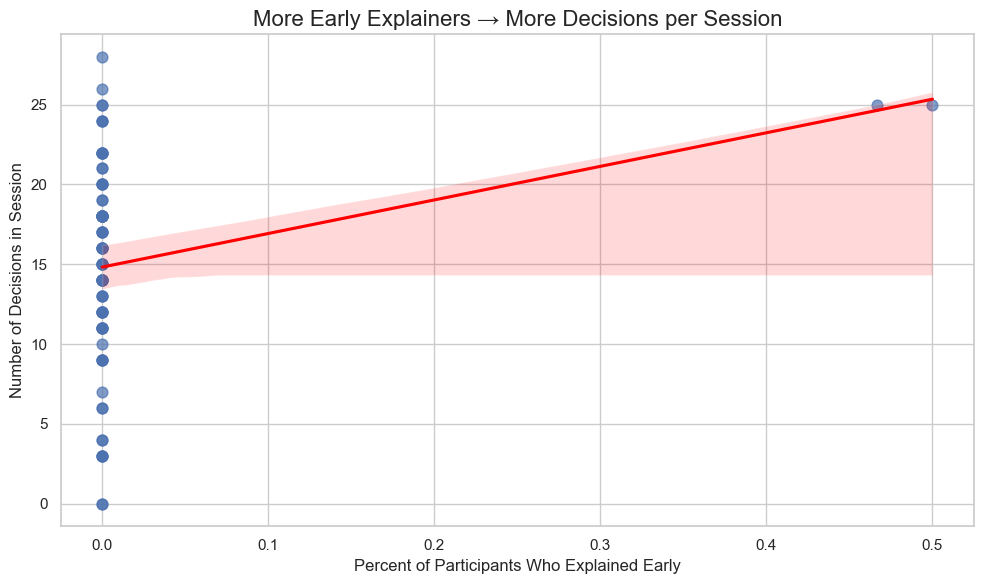

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
sns.set(style="whitegrid")

# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=session_df,
    x='percent_explained_early',
    y='num_decisions',
    scatter_kws={'s': 60, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

plt.title("More Early Explainers → More Decisions per Session", fontsize=16)
plt.xlabel("Percent of Participants Who Explained Early")
plt.ylabel("Number of Decisions in Session")
plt.tight_layout()
plt.show()


Sessions where at least ~50% of participants explained early had much higher decision counts (e.g. 25+)

Positive regression line ; more early explainers -> more decisions

- BUT: Most data points clustered at 0.0.

## Splitting into two groups:

(1) no early explainers

(2) some early explainers

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_98489/26562928.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


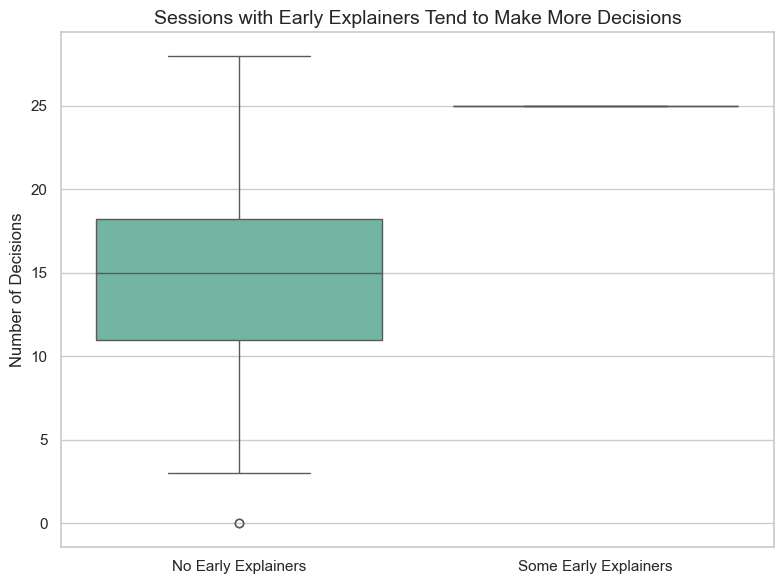

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create binary group
session_df['early_explainer_group'] = session_df['percent_explained_early'] > 0

# Plot decision counts by group
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=session_df,
    x='early_explainer_group',
    y='num_decisions',
    palette='Set2'
)

plt.xticks([0, 1], ['No Early Explainers', 'Some Early Explainers'])
plt.title("Sessions with Early Explainers Tend to Make More Decisions", fontsize=14)
plt.xlabel("")
plt.ylabel("Number of Decisions")
plt.tight_layout()
plt.show()


In [17]:
# Summary statistics by group
summary = session_df.groupby('early_explainer_group')['num_decisions'].describe()
print(summary)


                       count    mean       std   min   25%   50%    75%   max
early_explainer_group                                                        
False                   80.0  14.825  6.261748   0.0  11.0  15.0  18.25  28.0
True                     2.0  25.000  0.000000  25.0  25.0  25.0  25.00  25.0


## Non-parametric test

Since group sizes unequal

In [18]:
from scipy.stats import mannwhitneyu

# Split into groups
group_0 = session_df[session_df['early_explainer_group'] == False]['num_decisions']
group_1 = session_df[session_df['early_explainer_group'] == True]['num_decisions']

# Mann-Whitney U test
stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")


Mann-Whitney U Test: statistic=6.00, p-value=0.0268


Even though only 2 sessions had early explainers, both reached high decision counts (25). Mann-Whitney test shows a significant difference (p = 0.027), but due to the very small sample size in the "early explainer" group, we treat this as suggestive, not definitive. It still supports the idea that early contributions may correlate with downstream outcomes.

## Identifying Sessions

In [27]:
import pandas as pd
import ast

# Reload full utterance-level dataset
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

# If 'annotations' exists, parse it
if 'annotations' in df.columns:
    df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
else:
    print("❌ 'annotations' column not found in utterance-level data.")

# Step 1: Find sessions where someone explained early
early_sessions = speaker_stats[speaker_stats['explained_early'] == True]['global_session'].unique()

# Step 2: Filter utterances in early sessions that contain 'explain or define term or concept'
early_explainer_utterances = df[
    (df['global_session'].isin(early_sessions)) &
    (df['annotations'].apply(
        lambda annots: any(
            isinstance(d, dict) and 'explain or define term or concept' in d
            for d in annots
        )
    ))
]

# Step 3: Sort for readability
early_explainer_utterances = early_explainer_utterances.sort_values(['global_session', 'global_minute'])

# Preview
early_explainer_utterances[['global_session', 'speaker', 'global_minute', 'annotations', 'transcript']].head(10)




,global_session,speaker,global_minute,annotations,transcript
1922,2021_04_22_MND_S1_MND,Shikha Nangia,0.000000,[{'explain or define term or concept': 'The sp...,tell us through machine learning that people w...
1876,2021_04_22_MND_S1_MND,Yanjiao Zhou,1.000000,[{'explain or define term or concept': 'The sp...,"Uh, so, uh, I'm assistant professor uh in Yuko..."
1965,2021_04_22_MND_S1_MND,Erin Longbrake,1.366667,[{'explain or define term or concept': 'Erin i...,"Multiple sclerosis likewise, um perhaps even a..."
1878,2021_04_22_MND_S1_MND,Mei Shen,1.583333,[{'explain or define term or concept': 'The sp...,Hello everyone. So I am assistant professor an...
1882,2021_04_22_MND_S1_MND,Shikha Nangia,2.766667,[{'explain or define term or concept': 'The sp...,Hello everybody. My name is Shika Nagia. I'm a...
1884,2021_04_22_MND_S1_MND,Erin Longbrake,3.683333,[{'explain or define term or concept': 'The sp...,"Hi, I think I'm the outlier here. I'm more of ..."
2068,2021_04_22_MND_S1_MND,Andrew Feig,6.366667,[{'explain or define term or concept': 'This u...,One of the things we do is is a study of how n...
1920,2021_04_22_MND_S1_MND,Ashley Ross,7.033333,[{'acknowledge contribution': 'Mei Shen just s...,"Hi Meg, how are you? Um, so my lab actually we..."
1958,2021_04_22_MND_S1_MND,Ashley Ross,NaN,[{'explain or define term or concept': 'The sp...,"Um, well, I have one project in my lab that we..."
790,2021_04_22_MND_S3_MND,Elaine Hsiao,0.083333,[{'present new idea': 'Elaine introduces the i...,like kind of what we're alluding to. I am sign...


🔹 Top early explainers:
           speaker  num_explanations
5     Lisa Osborne                 3
1      Ashley Ross                 2
2     Elaine Hsiao                 2
3   Erin Longbrake                 2
7    Shikha Nangia                 2
0      Andrew Feig                 1
4  Faranak Fattahi                 1
6         Mei Shen                 1
8   Will Ludington                 1
9     Yanjiao Zhou                 1


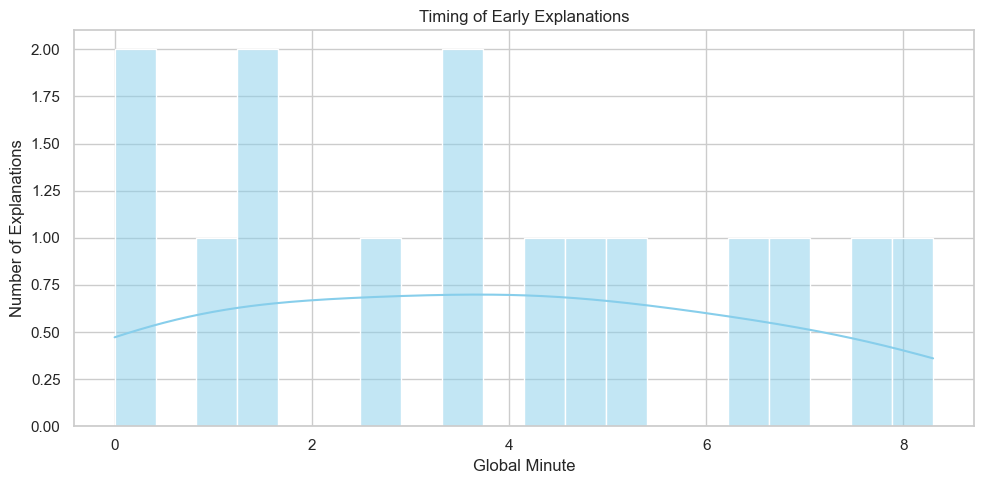


🔹 Outcome summary by early_explainer_group:


num_decisions                                          \
                              count      mean       std  min  25%  50%  75%   
early_explainer_group                                                         
False                        1149.0  1.032202  1.777670  0.0  0.0  0.0  1.0   
True                           25.0  2.000000  1.979057  0.0  0.0  2.0  3.0   

                            num_new_ideas            ...             \
                        max         count      mean  ...  75%   max   
early_explainer_group                                ...              
False                  12.0        1149.0  1.599652  ...  2.0  11.0   
True                    8.0          25.0  1.480000  ...  2.0   4.0   

                      num_explanations                                         \
                                 count     mean       std  min  25%  50%  75%   
early_explainer_group                                                           
False                           1149.0  1.97302  2.240381  0.0  0.0  1.0  3.0   
True                              25.0  1.92000  1.605200  0.0  1.0  1.0  3.0   

                             
                        max  
early_explainer_group        
False                  23.0  
True                    5.0  

[2 rows x 24 columns]

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- A. Count early explanations by speaker ---
explanation_counts = (
    early_explainer_utterances.groupby('speaker')
    .size()
    .reset_index(name='num_explanations')
    .sort_values('num_explanations', ascending=False)
)

print("🔹 Top early explainers:")
print(explanation_counts.head(10))


# --- B. Histogram of explanation timing ---
plt.figure(figsize=(10, 5))
sns.histplot(early_explainer_utterances['global_minute'], bins=20, kde=True, color='skyblue')
plt.title("Timing of Early Explanations")
plt.xlabel("Global Minute")
plt.ylabel("Number of Explanations")
plt.tight_layout()
plt.show()


# --- C. Compare session-level outcomes based on early explaining ---
# Create a boolean column: was this session part of early explanation group?
speaker_stats['early_explainer_group'] = speaker_stats['global_session'].isin(early_sessions)

# Compute summary stats for each group
outcome_summary = (
    speaker_stats.groupby('early_explainer_group')[['num_decisions', 'num_new_ideas', 'num_explanations']]
    .describe()
)

print("\n🔹 Outcome summary by early_explainer_group:")
display(outcome_summary)


num_decisions: U=19399.00, p=0.0009
num_new_ideas: U=14745.00, p=0.8136
num_explanations: U=15204.50, p=0.6068


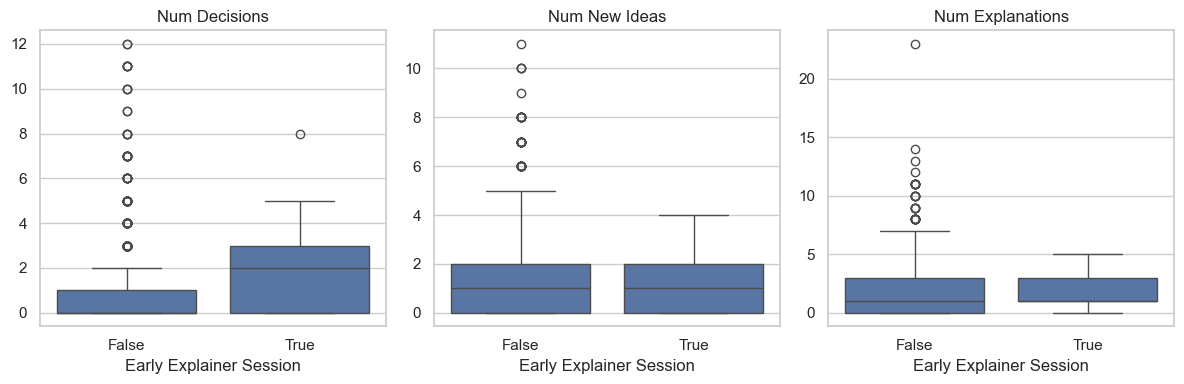

,speaker,global_minute,annotations,transcript
1922,Shikha Nangia,0.000000,[{'explain or define term or concept': 'The sp...,tell us through machine learning that people w...
1876,Yanjiao Zhou,1.000000,[{'explain or define term or concept': 'The sp...,"Uh, so, uh, I'm assistant professor uh in Yuko..."
1965,Erin Longbrake,1.366667,[{'explain or define term or concept': 'Erin i...,"Multiple sclerosis likewise, um perhaps even a..."
1878,Mei Shen,1.583333,[{'explain or define term or concept': 'The sp...,Hello everyone. So I am assistant professor an...
1882,Shikha Nangia,2.766667,[{'explain or define term or concept': 'The sp...,Hello everybody. My name is Shika Nagia. I'm a...
1884,Erin Longbrake,3.683333,[{'explain or define term or concept': 'The sp...,"Hi, I think I'm the outlier here. I'm more of ..."
2068,Andrew Feig,6.366667,[{'explain or define term or concept': 'This u...,One of the things we do is is a study of how n...
1920,Ashley Ross,7.033333,[{'acknowledge contribution': 'Mei Shen just s...,"Hi Meg, how are you? Um, so my lab actually we..."
1958,Ashley Ross,NaN,[{'explain or define term or concept': 'The sp...,"Um, well, I have one project in my lab that we..."
790,Elaine Hsiao,0.083333,[{'present new idea': 'Elaine introduces the i...,like kind of what we're alluding to. I am sign...


In [29]:
from scipy.stats import mannwhitneyu

group_true = speaker_stats[speaker_stats['early_explainer_group'] == True]
group_false = speaker_stats[speaker_stats['early_explainer_group'] == False]

for col in ['num_decisions', 'num_new_ideas', 'num_explanations']:
    stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')
    print(f"{col}: U={stat:.2f}, p={p:.4f}")

plt.figure(figsize=(12, 4))
for i, outcome in enumerate(['num_decisions', 'num_new_ideas', 'num_explanations']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=speaker_stats, x='early_explainer_group', y=outcome)
    plt.title(outcome.replace('_', ' ').title())
    plt.xlabel("Early Explainer Session")
    plt.ylabel("")

plt.tight_layout()
plt.show()

early_explainer_utterances[['speaker', 'global_minute', 'annotations', 'transcript']].head(10)




# Breaking Down By Conference and Highlight Top Speakers


📌 Conference: 2021
  num_decisions: U=19399.00, p=0.0009
  num_new_ideas: U=14745.00, p=0.8136
  num_explanations: U=15204.50, p=0.6068

  🔹 Top Early Explainers:
        speaker  num_explanations
   Lisa Osborne                 5
   Judith Eisen                 5
  Aida Ebrahimi                 4
    Ashley Ross                 4
Faranak Fattahi                 4


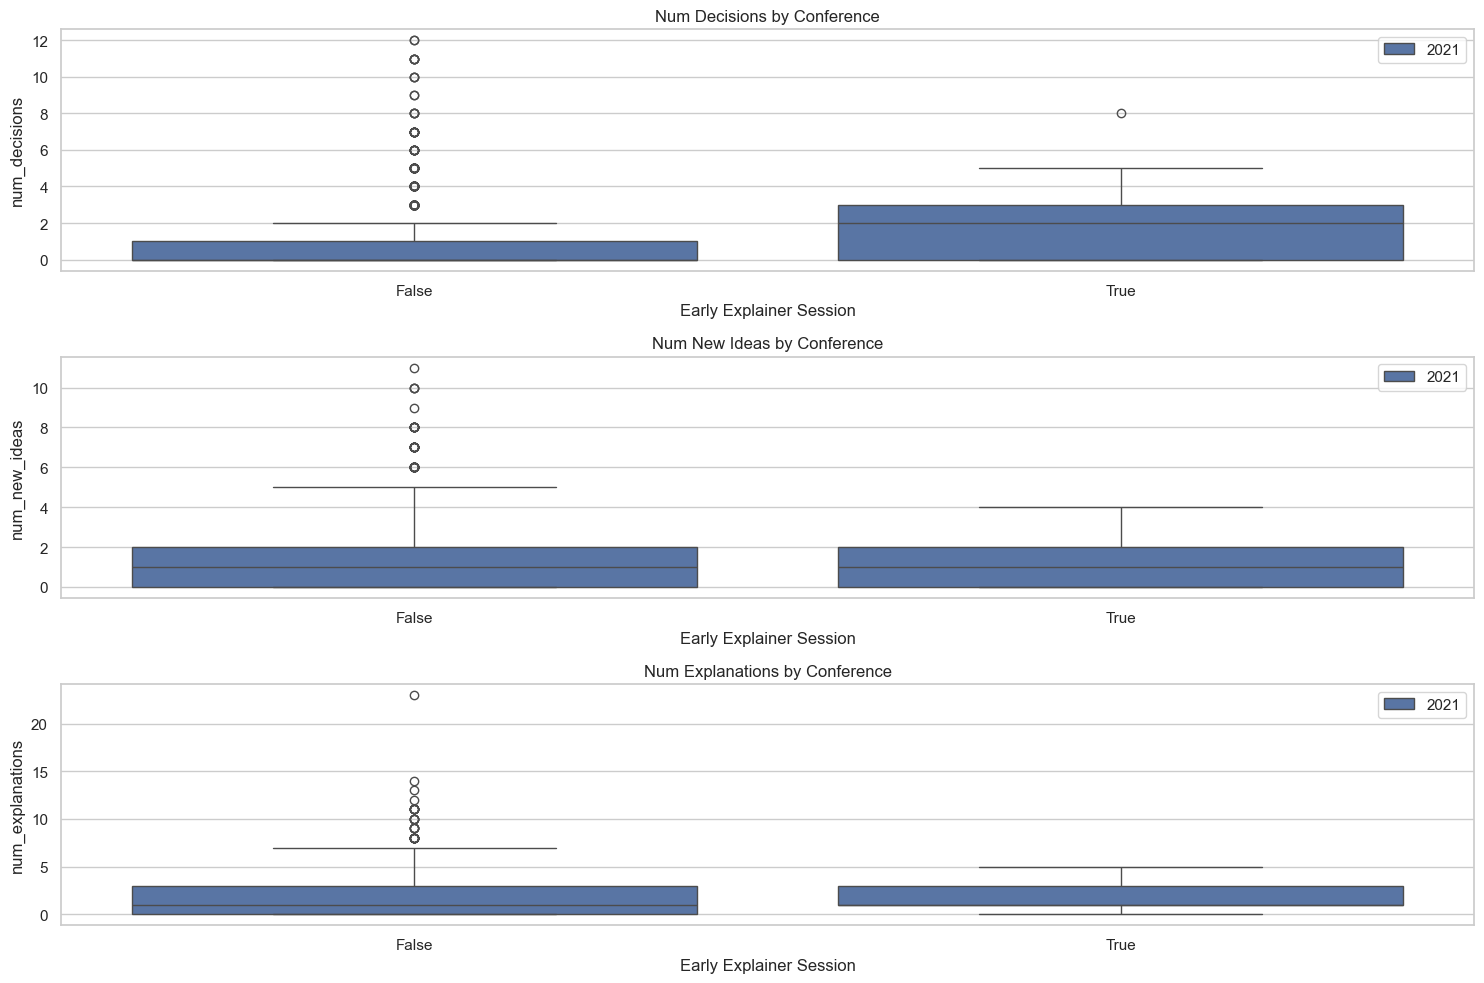

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Extract conference name
speaker_stats['conference'] = speaker_stats['global_session'].apply(lambda x: x.split('_')[0])

# Step 2: For each conference, run statistical tests + get top speakers
for conf in speaker_stats['conference'].unique():
    print(f"\n📌 Conference: {conf}")
    subset = speaker_stats[speaker_stats['conference'] == conf]

    group_true = subset[subset['early_explainer_group'] == True]
    group_false = subset[subset['early_explainer_group'] == False]

    for col in ['num_decisions', 'num_new_ideas', 'num_explanations']:
        stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')
        print(f"  {col}: U={stat:.2f}, p={p:.4f}")

    # Top speakers by explanation count (early explainer group only)
    top_explainers = group_true[['speaker', 'num_explanations']].sort_values('num_explanations', ascending=False).drop_duplicates('speaker').head(5)
    print("\n  🔹 Top Early Explainers:")
    print(top_explainers.to_string(index=False))

# Optional: visual breakdown per conference
plt.figure(figsize=(15, 10))
for i, outcome in enumerate(['num_decisions', 'num_new_ideas', 'num_explanations']):
    plt.subplot(3, 1, i+1)
    sns.boxplot(data=speaker_stats, x='early_explainer_group', y=outcome, hue='conference')
    plt.title(f"{outcome.replace('_', ' ').title()} by Conference")
    plt.xlabel("Early Explainer Session")
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import ast

# Load utterance-level dataset
df = pd.read_csv("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Flatten annotations for faster lookup
def has_code(annotation_list, target_code):
    return any(target_code in ann for ann in annotation_list if isinstance(ann, dict))

df['is_explanation'] = df['annotations'].apply(lambda lst: has_code(lst, 'explain or define term or concept'))
df['is_new_idea']   = df['annotations'].apply(lambda lst: has_code(lst, 'present new idea'))
df['is_decision']   = df['annotations'].apply(lambda lst: has_code(lst, 'decision made'))

# Speaker-level stats
speaker_stats = df.groupby(['conference', 'global_session', 'speaker']).agg(
    total_speaking_duration=('speaking_duration', 'sum'),
    num_utterances=('transcript', 'count'),
    num_explanations=('is_explanation', 'sum'),
    num_new_ideas=('is_new_idea', 'sum'),
    num_decisions=('is_decision', 'sum'),
    first_explanation_minute=('global_minute', lambda x: x[df.loc[x.index, 'is_explanation']].min() if (df.loc[x.index, 'is_explanation']).any() else float('nan')),
    mentions_research=('transcript', lambda x: x.str.contains("research", case=False).sum()),
).reset_index()

# Did the speaker explain within the first 5 minutes?
speaker_stats['explained_early'] = speaker_stats['first_explanation_minute'] <= 5

# Mark sessions where at least one speaker explained early
early_sessions = speaker_stats[speaker_stats['explained_early']]['global_session'].unique()
speaker_stats['early_explainer_group'] = speaker_stats['global_session'].isin(early_sessions)

# outputting
speaker_stats.head(10)


,conference,global_session,speaker,total_speaking_duration,num_utterances,num_explanations,num_new_ideas,num_decisions,first_explanation_minute,mentions_research,explained_early,early_explainer_group
0,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Aida Ebrahimi,784.0,26,0,0,0,NaN,0,False,True
1,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Amina Schartup,13.0,1,0,0,0,NaN,0,False,True
2,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Andrew Feig,25.0,2,1,0,0,6.366667,0,False,True
3,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Arida Ebrahimi,116.0,9,0,0,0,NaN,0,False,True
4,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Ashley Ross,198.0,9,2,1,0,7.033333,0,False,True
5,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Barbara Bendlin,438.0,56,0,1,0,NaN,1,False,True
6,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Chris Whidbey,179.0,9,0,0,0,NaN,0,False,True
7,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Chris Whitlatch,0.0,1,0,0,0,NaN,0,False,True
8,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Chris Windey,226.0,20,0,0,0,NaN,0,False,True
9,2021_04_22_MND_S1,2021_04_22_MND_S1_MND,Erin Longbrake,371.0,21,2,2,0,1.366667,2,True,True


## Running Per-Conference Analysis

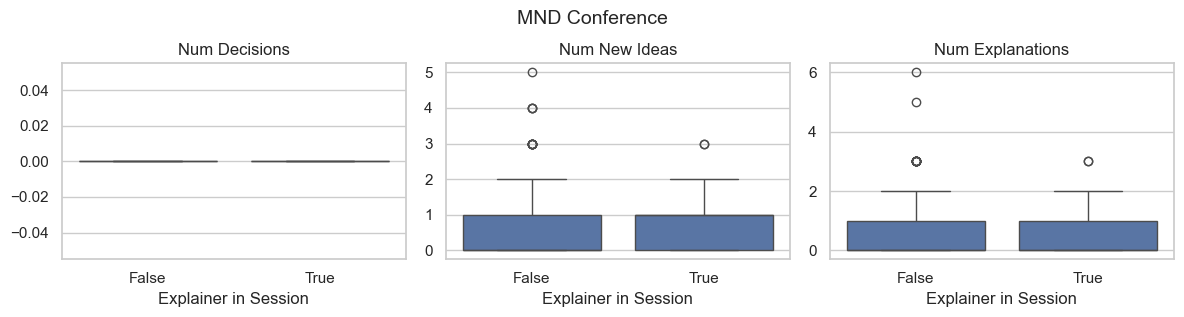

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_98489/879586078.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')


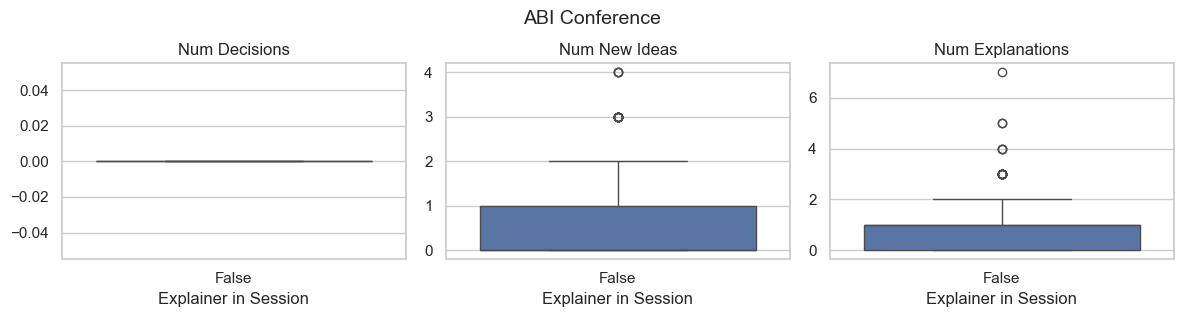

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_98489/879586078.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')


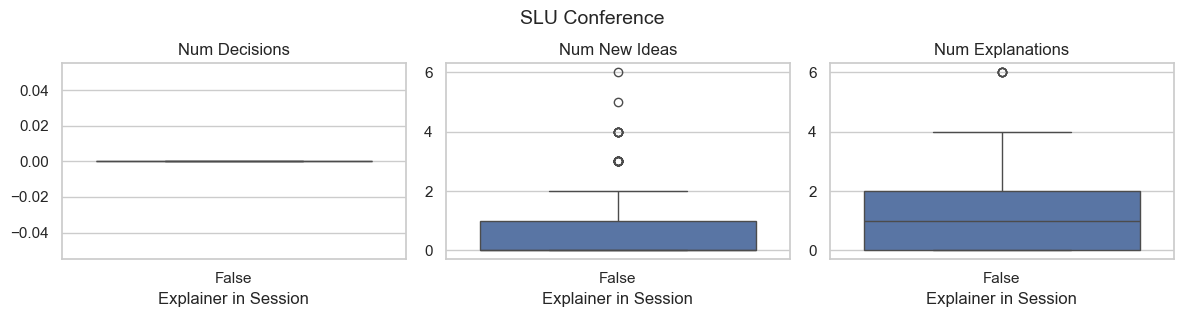

/var/folders/17/lphw45ds14n5t74zwjdfybx40000gn/T/ipykernel_98489/879586078.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')


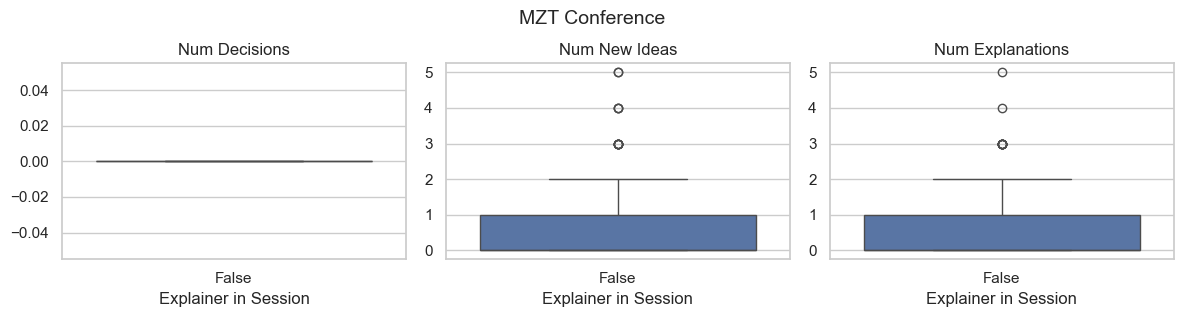

In [45]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Extract abbreviation from the 'conference' column
speaker_stats['conference_abbr'] = speaker_stats['conference'].str.extract(r'_(MND|SLU|ABI|MZT)')[0]

results = []
top_speakers_dict = {}

# Loop over each unique conference abbreviation
for conf_abbr in speaker_stats['conference_abbr'].dropna().unique():
    subset = speaker_stats[speaker_stats['conference_abbr'] == conf_abbr]
    
    group_true = subset[subset['early_explainer_group']]
    group_false = subset[~subset['early_explainer_group']]

    conf_results = {"conference_abbr": conf_abbr}
    
    for col in ['num_decisions', 'num_new_ideas', 'num_explanations']:
        stat, p = mannwhitneyu(group_true[col], group_false[col], alternative='two-sided')
        conf_results[f"{col}_U"] = stat
        conf_results[f"{col}_p"] = p
    
    results.append(conf_results)

    # Top 5 early explainers
    top_explainers = (
        subset[subset['explained_early']]
        .groupby('speaker')['num_explanations']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .reset_index()
    )
    top_speakers_dict[conf_abbr] = top_explainers

    # Optional: boxplots
    plt.figure(figsize=(12, 3))
    for i, metric in enumerate(['num_decisions', 'num_new_ideas', 'num_explanations']):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(data=subset, x='early_explainer_group', y=metric)
        plt.title(metric.replace("_", " ").title())
        plt.xlabel("Explainer in Session")
        plt.ylabel("")
    plt.tight_layout()
    plt.suptitle(f"{conf_abbr} Conference", y=1.05, fontsize=14)
    plt.show()

# Display results as table
summary_df = pd.DataFrame(results)

Across all four conferences, speakers in sessions with early explainers did not show significantly different rates of new idea contributions or explanations. The 'early explainer' group was sparse or almost absent in most sessions. Furthermore, decision-making utterances were rare, with `num_decisions = 0` for most speakers, suggesting this variable may not be useful for analysis.

# Transcript Keyword Parsing

In [47]:
import re

# Define common intro patterns (expandable if needed)
intro_patterns = [
    r"\b(i[' ]?m a\b)",             # I'm a
    r"\b(i am a\b)",                # I am a
    r"\bmy name is\b",              # My name is
    r"\bi work (on|in|with)\b",     # I work on/in/with
    r"\bmy research\b",             # My research
    r"\bi study\b"                  # I study
]

# Combine into one regex pattern (case-insensitive)
intro_regex = re.compile("|".join(intro_patterns), flags=re.IGNORECASE)

# Flag whether the utterance is a self-introduction
df['is_self_intro'] = df['transcript'].apply(lambda x: bool(intro_regex.search(str(x))))

# Optional: Check how often self-intros are labeled as explanations
df['is_intro_and_explainer'] = df['is_self_intro'] & df['is_explanation']

# Show some example matches
intro_examples = df[df['is_self_intro']][['speaker', 'global_minute', 'transcript', 'is_explanation']].head(10)

# Quick stats
num_intro = df['is_self_intro'].sum()
num_intro_as_explainer = df['is_intro_and_explainer'].sum()

print(f"🔍 Total self-introduction utterances: {num_intro}")
print(f"🧠 Of those, how many were labeled as 'explanation': {num_intro_as_explainer}")


🔍 Total self-introduction utterances: 484
🧠 Of those, how many were labeled as 'explanation': 189


## STUFF TO DO (later sections):

- participant's introductions / qualifications.

